## Complementarity & Accessibilty

### 1.  Imports & Declarations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import DBSCAN
# from haversine import haversine as hs
import requests
%matplotlib inline
# from pydantic_settings import BaseSettings
#from ydata_profiling import ProfileReport

import sys
import os
sys.path.append('../utils/')
#sys.path.append('..\\utils\\')

from functions import get_zone_info
from functions import haversine_distance as hsd
from functions import main_concurrent

In [2]:
##############################################################################################################
# GREEN MOBILITY
##############################################################################################################

# Initialize dataframe
file_path = "../data/processed/gm_raw.csv"
gm_source = pd.read_csv(file_path)

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.

# Add columns if necessary

#################################################################################################################
# DRIVE NOW
#################################################################################################################

# 1. Initialize dataframe
file_path = "../data/raw/DriveNow/DTU - data til case_LTMZones1.csv"
sn_source = pd.read_csv(file_path, sep=";")

# 2. Rename columns if necessary
sn_source.rename(columns= {
                            "Latitude (Start)": "LatitudeStart", 
                            "Longitude (Start)": "LongitudeStart", 
                            'Latitude (Slut)': "LatitudeEnd", 
                            'Longitude (Slut)':'LongitudeEnd',
                            'Reservationstidspunkt': "ReservationTime",
                            'Start tidspunkt': "StartTime",
                            'Slut tidspunkt': "EndTime",
                            'Alder': "Age",
                            'Køn': "Gender",
                            'Batteristatus (start)': "BatteryStart",
                            'Batteristatus (slut)':"BatteryEnd",
                            'Km kørt': "KmDriven"
                            }, inplace=True)

# 3. Drop columns if necessary
sn_source.drop(columns=['TurID'],inplace=True)

# 4. Convert to appropriate data types
# Convert to Numeric the following columns:
coordinates = [
    'LatitudeEnd',
    'LatitudeStart',
    'LongitudeEnd',
    'LongitudeStart'
]

for col in coordinates:
    sn_source[col] = sn_source[col].apply(lambda x: x.replace(',','.'))
    sn_source[col] = pd.to_numeric(sn_source[col],errors='coerce')

target_ls = [
    'KmDriven',
    'BatteryStart',
    'BatteryEnd',
]
for col in target_ls:
    sn_source[col] = pd.to_numeric(sn_source[col],errors='coerce')

sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime


# 5. Auxiliary columns
sn_source['TripDurationHours'] = (sn_source['EndTime'] - sn_source['StartTime']).dt.total_seconds()/3600
sn_source['TripDurationMinutes'] = sn_source['TripDurationHours']*60  #   trip duration in min
sn_source['AvgSpeed'] = sn_source['KmDriven']/sn_source['TripDurationHours'] #   avg speed

sn_source['Month'] = sn_source['StartTime'].dt.strftime("%B").astype('category')  #   month
sn_source['Weekday'] = sn_source['StartTime'].dt.day_name().astype('category')    #   day of the week
sn_source['StartHour'] = sn_source['StartTime'].dt.hour.astype('category')    #   hour of the day

# 6. Descriptive statistics
sn_source.describe()

# 7. Drop outliers, missing values, etc.

# drop rows with missing values
sn_source.dropna(inplace=True)

# drop rows with BatteryEnd more than BatteryStart
sn_source = sn_source[sn_source['BatteryStart'] >= sn_source['BatteryEnd']]

# drop rows with coordinates equal to 0 
for col in coordinates:
    sn_source = sn_source[(sn_source[col] != 0)|(sn_source[col] != '')]


# replace negative BatteryEnd with 0
sn_source['BatteryEnd'] = sn_source['BatteryEnd'].apply(lambda x: 0 if x < 0 else x)

# # drop rows with negative and avg speed > 100 km/h
sn_source = sn_source[(sn_source['AvgSpeed'] > 1) & (sn_source['AvgSpeed'] < 100)]


# # 8. Add columns if necessary
# # Add haversise distance to the dataframe
sn_source['HaversineDistance'] = hsd(sn_source['LatitudeStart'], sn_source['LongitudeStart'],sn_source['LatitudeEnd'], sn_source['LongitudeEnd'])
# sn_source['HaversineDistance'] = sn_source['HaversineDistance'].apply(lambda x: round(x,0))

# # drop rows with Haversine distance > 1000 km
sn_source = sn_source[sn_source['HaversineDistance'] < 1000]

##################################################################################################################
# DONKEY REPUBLIC
##################################################################################################################


# Initialize Donkey Republic dataframe
# file_path = ""
# donkey_source = ""

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.



/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_83063/1770929939.py:25: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  sn_source = pd.read_csv(file_path, sep=";")
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_83063/1770929939.py:67: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_83063/1770929939.py:68: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime


## Visualizations

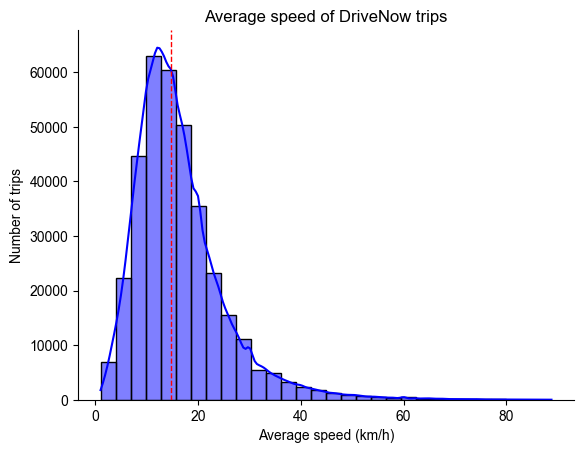

In [3]:
# plot histogram of average speed between 0 and 90 km/h using seaborn 
sns.histplot(data=sn_source[(sn_source['AvgSpeed']>0) & (sn_source['AvgSpeed']<90)], x="AvgSpeed", bins=30, color='blue', kde=True)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')

sns.despine()

# add title and labels
plt.title("Average speed of DriveNow trips")
plt.xlabel("Average speed (km/h)")
plt.ylabel("Number of trips")
plt.grid(False)
# plt.show()

# show median on the plot
plt.axvline(x=sn_source['AvgSpeed'].median(), color='red', linestyle='--', linewidth=1)
plt.show()

#### 2.1 Short Trips ShareNow: Clustering and Analysis

In [4]:
# Define short trips :: trips with distance between 5 and 40 km
sn_shorttrips = sn_source[(sn_source['KmDriven'] < 40)&(sn_source['KmDriven']>=3)]

# print the percentage of short trips using f string

print(f'{sn_shorttrips.shape[0]/sn_source.shape[0]}')

0.8723156434718756


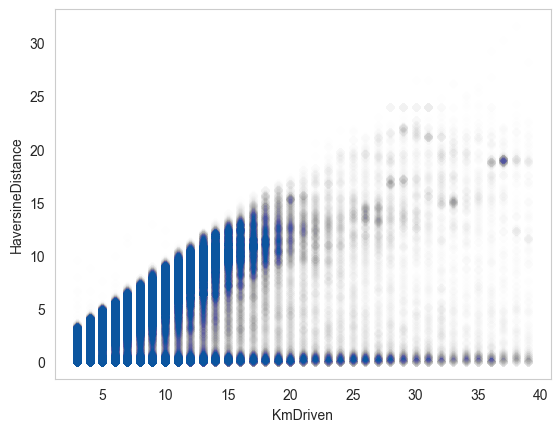

In [5]:
sns.scatterplot(data=sn_shorttrips, x="KmDriven", y="HaversineDistance", alpha=0.005)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

### ShareNow Short Trips :: Clusters on scatter plot

#### Estimate the values for $\epsilon$ and Minimum samples

In [6]:
# from sklearn.neighbors import NearestNeighbors
# import plotly.express as px

# neighbors = NearestNeighbors(n_neighbors=50)
# neighbors_fit = neighbors.fit(sn_shorttrips[['KmDriven', 'HaversineDistance']])
# distances, indices = neighbors_fit.kneighbors(sn_shorttrips[['KmDriven', 'HaversineDistance']])

# distances = np.sort(distances, axis=0)
# distances = distances[:,1]

# # line plot with plotly express for distances
# fig = px.line(x=range(len(distances)), y=distances)
# fig.show()


# plt.plot(distances)

In [34]:
# run DBSCAN clustering algorithm on KmDriven and HaversineDistance

db = DBSCAN(eps=0.45, min_samples=5000, n_jobs=-1).fit(sn_shorttrips[['KmDriven','HaversineDistance']])

# add the cluster labels to the dataframe
sn_shorttrips['Cluster'] = db.labels_

/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_83063/2610041558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sn_shorttrips['Cluster'] = db.labels_


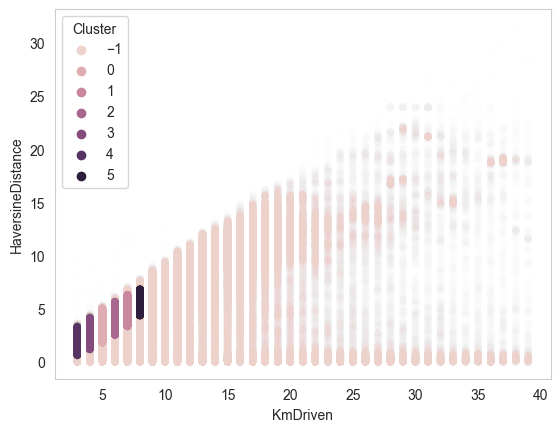

In [35]:
sns.scatterplot(data=sn_shorttrips, x="KmDriven", y="HaversineDistance", hue='Cluster',alpha=0.005)
# change color of histogram
# sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

In [38]:
# sn_shorttrips[sn_shorttrips['Cluster']>-1].shape[0]/sn_shorttrips.shape[0]*100
sn_shorttrips['Cluster'].value_counts()

Cluster
-1    125274
 3     40412
 0     38238
 4     35891
 2     31521
 1     23561
 5     15158
Name: count, dtype: int64

## STATISTICAL ANALYSIS : Hypothesis testing